# Calculate p-values for each gene

The whack-a-probe optimization/training process results in a ranked list of genes where the gene's ranking is its only quantitative attribute. But we would like to report the probability we discovered any particular gene purely by chance, a p-value. To do this, we compare the average ranking each gene achieved in 16 split-half real data sets against the ranking the gene achieved in 256 runs of each of three permutation algorithms. A gene that was consistently ranked higher in real data than it was in shuffled data would have a low p-value.

$$p = {times gene ranked higher in permuation} \over 256$$

A second approach counts each individual real ranking (rather than averages) against each individual shuffled ranking, which is 4,096 comparisons.


In [5]:
""" Define some lists for looping. """
masks = ['16', '32', ]
shuffles = ["agno", "dist", "edge", ]
norms = ["", "s", ]

In [6]:
""" Load up the data, preprocessed by the ge_data_manager project.
    We won't use this to generate rankings, but we can see quickly
    where the peaks are in each run. """

import pickle

pre_calc_results = {}
for mask in masks:
    for norm in norms:
        cache_file = "/data/plots/cache/hcpww{}s{}peak_ol_post.df".format(mask, norm)
        try:
            with open(cache_file, "br") as f:
                print(cache_file)
                pre_calc_results[(mask, norm)] = pickle.load(f)
                derivatives = pre_calc_results[(mask, norm)][pre_calc_results[(mask, norm)]['shuffle'] == 'none']
                print("  Peak for {} at {:,} +/- {:0.0f}".format(
                    mask,
                    15745 - int(derivatives['peak'].mean()),
                    derivatives['peak'].std(),
                ))
                for shuffle in shuffles:
                    shuffled = pre_calc_results[(mask, norm)][pre_calc_results[(mask, norm)]['shuffle'] == shuffle]
                    print("     {} {} at {:,} +/- {:0.0f}".format(
                        mask, shuffle,
                        15745 - int(shuffled['peak'].mean()),
                        shuffled['peak'].std(),
                    ))
        except FileNotFoundError as e:
            print("{} not found.".format(cache_file))


/data/plots/cache/hcpww16speak_ol_post.df
  Peak for 16 at 72 +/- 14
     16 agno at 89 +/- 25
     16 dist at 79 +/- 24
     16 edge at 46 +/- 12
/data/plots/cache/hcpww16sspeak_ol_post.df
  Peak for 16 at 70 +/- 18
     16 agno at 89 +/- 24
     16 dist at 73 +/- 21
     16 edge at 30 +/- 8
/data/plots/cache/hcpww32speak_ol_post.df
  Peak for 32 at 77 +/- 14
     32 agno at 90 +/- 25
     32 dist at 78 +/- 23
     32 edge at 46 +/- 13
/data/plots/cache/hcpww32sspeak_ol_post.df
  Peak for 32 at 70 +/- 15
     32 agno at 89 +/- 23
     32 dist at 73 +/- 22
     32 edge at 30 +/- 8


## Calculate p-values

Define functions to import all rankings into a single dataframe. Rank them all. Then calculate p-values. We calculate the old intensive way first, then add onto that dataframe with the faster vectorized method.

In [7]:
""" Modified from ge_data_manager to include shuffled data,
    the ranked_probes function iterates over result tsvs, ranking genes and saving them
    into a single dataframe. """

import pandas as pd
from pygest import algorithms
from pygest.convenience import bids_val
from pygest.rawdata import miscellaneous


def name_from_path(path):
    """ Extract critical pieces from the path to return an abbreviated column name, like "agno-203-002-s".
        Three items differ in each path: 4 shuffle-types, 16 splits, 16 seeds (plus None). """
    
    shuffle = bids_val("shuffle", path)
    if shuffle == "random":
        shuffle = "agno" 
    if shuffle == "actual":
        shuffle = "real" 
    
    batch = bids_val("batch", path)[-3:]
    seed = bids_val("seed", path)[-3:]
    norm = "s" if bids_val("norm", path) == "srs" else "none"
    
    return "{}-{}-{}-{}".format(shuffle, batch, seed, norm)

    
def ranked_probes(tsvs):
    """ Go through the files provided, saving ranked probes for each. """

    report_progress_on_items = range(int(len(tsvs)/10), len(tsvs), int(len(tsvs)/10))
    all_rankings = pd.DataFrame()
    for i, tsv in enumerate(tsvs):
        df = pd.read_csv(tsv, sep='\t')
        rankings = pd.Series(data=df.index, index=df['probe_id'], name=name_from_path(tsv))
        if i == 0:
            all_rankings = pd.DataFrame(data=rankings)
        else:
            all_rankings[rankings.name] = rankings
        # if i in report_progress_on_items:
        #     print("Ranked {} of {} and counting...".format(i, len(tsvs)))
        if i == len(tsvs):
            print("    ranked all probes in {} results.".format(i + 1))
    all_rankings['mean'] = all_rankings.mean(axis=1)
    all_rankings['entrez_id'] = all_rankings.index.map(miscellaneous.map_pid_to_eid_fornito)
    return all_rankings.sort_values('mean', ascending=True)


In [8]:
""" Rank probes/genes for each and every run. """

rankings = {}
for mask in masks:
    for norm in norms:
        tsv_files = pre_calc_results[(mask, norm)]['path']
        rankings[(mask, norm)] = ranked_probes(tsv_files, None)

In [9]:
""" We can borrow the id-to-symbol map from PyGEST.
    (although it would be better to build a reproducible routine to extract it from updated human_gene_info files.) """

from pygest import convenience

id_to_symbol_map = convenience.create_id_to_symbol_map()
for mask in masks:
    for norm in norms:
        rankings[(mask, norm)]['gene_symbol'] = rankings[(mask, norm)]['entrez_id'].map(id_to_symbol_map)

In [10]:
""" Determine, for each probe/gene, how likely it is for a real ranking to be higher than a shuffled ranking.
    This is the c-style, expensive, 4k-comparison approach. """

import numpy as np

def p_probe(probe_id, df):
    """ Return probability (p-value) a real rank is higher than shuffled. """
    
    ps = {}
    real_runs = [c for c in df.columns if "real" in c]
    for shuf in ["agno", "dist", "edge", ]:
        shuffled_runs = [c for c in df.columns if shuf in c]

        n_better = 0
        n_worse = 0
        n_total = 0
        for real in df.loc[probe_id, real_runs]:
            for baseline in df.loc[probe_id, shuffled_runs]:
                n_total += 1
                if real < baseline:
                    n_better += 1
                else:
                    n_worse += 1
            # print("    {} vs {} of {}".format(n_better, n_worse, n_total))
        ps[shuf] = n_worse / n_total

        # print("Mean real rank = {:,} vs mean {} rank of {:,}; {:,} better, {:,} worse, out of {:,}; p = {:0.3f}".format(
        #     int(np.mean(df.loc[probe_id, real_runs])), shuf, int(np.mean(df.loc[probe_id, shuffled_runs])),
        #     n_better, n_worse, n_total, ps[shuf]
        # ))
        
    return ps["agno"], ps["dist"], ps["edge"]

In [11]:
""" Manually sample a few genes that came out in the prior algorithm as good, ok, and bad.
    Use just this small subset to rapidly prototype and check old vs new algorithms. """ 

# selected_ids = [57622, 8178, 728882, 10605, 23395, 1482, 9865, ]
# selected_ids = set(selected_ids).union(set(rankings["16"].sample(16)['entrez_id']))
# selected_probes = list(rankings["16"][rankings["16"]["entrez_id"].isin(selected_ids)]["entrez_id"].index)


' Manually sample a few genes that came out in the prior algorithm as good, ok, and bad.\n    Use just this small subset to rapidly prototype and check old vs new algorithms. '

In [12]:
""" Calculate p-values for real vs each of three shuffle types.
    This employs the c-style time intenstive process that performs ~4000 comparisons per gene. """

import pandas as pd
import datetime

df_p_values = {}
for mask in masks:
    for norm in norms:
        print(datetime.datetime.now())
        p_values = {}
        print("Calculating p-values for {}mm-masked results.".format(mask))
        for pid in rankings[(mask, norm)].index:  # replace me with selected_probes to limit how many genes are tested.
            p_a, p_d, p_e = p_probe(pid, rankings[(mask, norm)])
            p_values[pid] = {
                'entrez_id': int(rankings[(mask, norm)].loc[pid, 'entrez_id']),
                'gene_symbol': rankings[(mask, norm)].loc[pid, 'gene_symbol'],
                'old_agno': p_a,
                'old_dist': p_d,
                'old_edge': p_e,
            }
        df_p_values[(mask, norm)] = pd.DataFrame(data=p_values).T
        df_p_values[(mask, norm)]['entrez_id'] = df_p_values[(mask, norm)]['entrez_id'].astype(int)
        # df_p_values[(mask, norm)] = df_p_values[(mask, norm)].set_index('entrez_id')


2019-12-20 17:32:33.093887
Calculating p-values for 16mm-masked results.
2019-12-20 17:47:38.648591
Calculating p-values for 16mm-masked results.
2019-12-20 18:02:11.616604
Calculating p-values for 32mm-masked results.
2019-12-20 18:16:55.053676
Calculating p-values for 32mm-masked results.


In [13]:
""" Calculate p values by simply counting how many shuffled rankings are better
    than the average real ranking. This is only 256 comparisons. """

import numpy as np

for mask in masks:
    for norm in norms:
        reals = rankings[(mask, norm)].loc[:, [x for x in rankings[(mask, norm)].columns if "real" in x]]
        real_means = reals.apply(np.mean, axis=1)

        for shuffle in shuffles:
            permuted_rankings = rankings[(mask, norm)].loc[:, [x for x in rankings[(mask, norm)].columns if shuffle in x]]
            hits = permuted_rankings.lt(real_means, axis=0)
            df_p_values[(mask, norm)]['new_' + shuffle] = hits.sum(axis=1) / hits.count(axis=1)


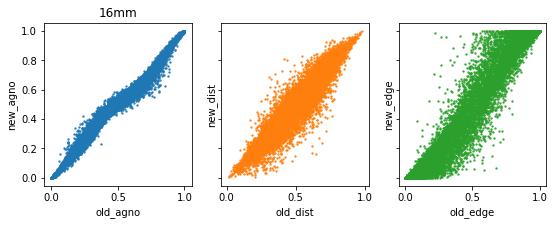

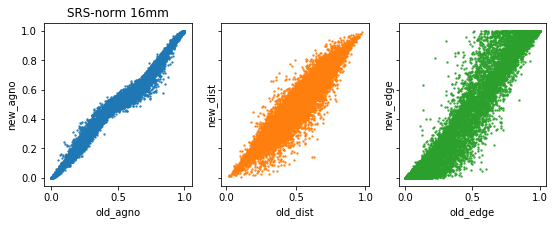

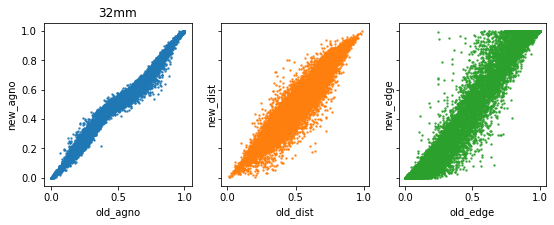

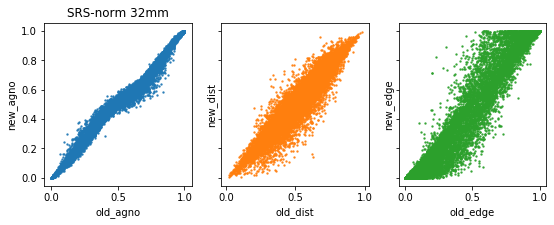

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

for mask in masks:
    for norm in norms:
        fig, axes = plt.subplots(ncols=3, figsize=(9,3), sharey=True)
        sns.regplot(x="old_agno", y="new_agno", data=df_p_values[(mask, norm)], fit_reg=False, scatter_kws={'s': 2}, ax=axes[0])
        sns.regplot(x="old_dist", y="new_dist", data=df_p_values[(mask, norm)], fit_reg=False, scatter_kws={'s': 2}, ax=axes[1])
        sns.regplot(x="old_edge", y="new_edge", data=df_p_values[(mask, norm)], fit_reg=False, scatter_kws={'s': 2}, ax=axes[2])
        axes[0].set_title("{}{}mm".format("SRS-norm " if norm == "s" else "", mask))
        fig.savefig("./old_vs_new_p_{}_{}.png".format(mask, norm))

In [19]:
""" Define a kernel-density plot to assist in visualizing the distributions of rankings. """

import seaborn as sns
import matplotlib.pyplot as plt

flatten = lambda l: [x for y in l for x in y]

def plot_entrez_id(entrez_id, rank_data, p_data, algo):
    """ Plot ranking distributions for one entrez id. """
    fig, ax = plt.subplots()
    real_list = flatten(rank_data[rank_data['entrez_id'] == entrez_id][[x for x in rank_data.columns if "real" in x]].values)
    real_label = "real"
    sns.distplot(real_list, ax=ax, kde_kws={"color": "black", "label": real_label}, hist_kws={"color": "gray"})
    agno_list = flatten(rank_data[rank_data['entrez_id'] == entrez_id][[x for x in rank_data.columns if "agno" in x]].values)
    agno_label = "vs agno, p = {:0.5f}".format(p_data.loc[entrez_id, algo + '_agno'])
    sns.distplot(agno_list, ax=ax, kde_kws={"color": "green", "label": agno_label}, hist_kws={"color": "lightgreen"})
    dist_list = flatten(rank_data[rank_data['entrez_id'] == entrez_id][[x for x in rank_data.columns if "dist" in x]].values)
    dist_label = "vs dist, p = {:0.5f}".format(p_data.loc[entrez_id, algo + '_dist'])
    sns.distplot(dist_list, ax=ax, kde_kws={"color": "red", "label": dist_label}, hist_kws={"color": "mistyrose"})
    edge_list = flatten(rank_data[rank_data['entrez_id'] == entrez_id][[x for x in rank_data.columns if "edge" in x]].values)
    edge_label = "vs edge, p = {:0.5f}".format(p_data.loc[entrez_id, algo + '_edge'])
    sns.distplot(edge_list, ax=ax, kde_kws={"color": "magenta", "label": edge_label}, hist_kws={"color": "lavenderblush"})
    fig.suptitle("Entrez ID {} ({} p)".format(entrez_id, algo))
    return fig, ax

# f, a = plot_entrez_id(57622, rankings["16"], df_p_values[("16", "")].set_index('entrez_id'))

In [21]:
""" Save out a csv file with entrez ids ordered by p-value for each mask and shuffle type. """

import random

for mask in masks:
    for norm in norms:
        for algo in ["new", "old", ]:
            eids_all_good = set(df_p_values[(mask, norm)]['entrez_id'])
            eids_all_bad = set(df_p_values[(mask, norm)]['entrez_id'])
            for shuffle in shuffles:
                print("{} {}_{}_{} {:,} probes with p < 0.05".format(
                    mask, algo, norm, shuffle, (df_p_values[(mask, norm)][algo + "_" + shuffle] < 0.05).sum()
                ))
                for id in ["gene_symbol", "entrez_id", ]:
                    df = df_p_values[(mask, norm)][[id, algo + "_" + shuffle]].set_index(id).sort_values(algo + "_" + shuffle)
                    df = df.rename(columns={algo + "_" + shuffle: "p"})
                    df.to_csv("./hcpww{}s{}_{}_{}_p_by_{}.tsv".format(mask, norm, algo, shuffle, id), sep="\t")

                eids_all_good = eids_all_good.intersection(set(df['p'][df['p'] < 0.05].index))
                eids_all_bad = eids_all_bad.intersection(set(df['p'][df['p'] >= 0.05].index))

            print("Mask {} has {} probes surviving all {} p-tests.".format(mask, len(eids_all_good), algo))
            print("    {}".format(sorted(list(eids_all_good))[:12]))
            eid_to_plot = random.sample(eids_all_good, 3)[0]
            f, a = plot_entrez_id(eid_to_plot, rankings[(mask, norm)], df_p_values[(mask, norm)].set_index('entrez_id'), algo)
            f.savefig("good_{}_{}_{}.png".format(mask, norm, eid_to_plot))
            f.clear()

            print("Mask {} has {} probes failing all {} p-tests.".format(mask, len(eids_all_bad), algo))
            print("    {}".format(sorted(list(eids_all_bad))[:12]))
            eid_to_plot = random.sample(eids_all_bad, 3)[0]
            f, a = plot_entrez_id(eid_to_plot, rankings[(mask, norm)], df_p_values[(mask, norm)].set_index('entrez_id'), algo)    
            f.savefig("bad_{}_{}_{}.png".format(mask, norm, eid_to_plot))
            f.clear()


16 new__agno 361 probes with p < 0.05
16 new__dist 51 probes with p < 0.05
16 new__edge 3,910 probes with p < 0.05
Mask 16 has 5 probes surviving all new p-tests.
    [9607, 9734, 57622, 80036, 130367]
Mask 16 has 11636 probes failing all new p-tests.
    [1, 2, 12, 16, 18, 19, 20, 21, 22, 23, 25, 27]
16 old__agno 333 probes with p < 0.05
16 old__dist 10 probes with p < 0.05
16 old__edge 2,404 probes with p < 0.05
Mask 16 has 5 probes surviving all old p-tests.
    [9607, 9734, 10451, 57622, 80036]
Mask 16 has 13140 probes failing all old p-tests.
    [1, 2, 12, 14, 16, 18, 19, 20, 21, 22, 23, 25]
16 new_s_agno 410 probes with p < 0.05
16 new_s_dist 53 probes with p < 0.05
16 new_s_edge 4,167 probes with p < 0.05
Mask 16 has 8 probes surviving all new p-tests.
    [286, 9607, 9734, 10195, 57622, 130367, 150568, 171019]
Mask 16 has 11396 probes failing all new p-tests.
    [1, 12, 18, 19, 21, 22, 23, 29, 30, 32, 34, 36]
16 old_s_agno 370 probes with p < 0.05
16 old_s_dist 12 probes with

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

# How different are SRS normalized vs original AHBA lists?

----------

In [62]:
""" Figure out the highest ranked genes, just by Mantel. """

from pygest.rawdata import miscellaneous

mask="16"
norm="s"

reals = rankings[(mask, norm)].loc[:, [x for x in rankings[(mask, norm)].columns if "real" in x]]
agnos = rankings[(mask, norm)].loc[:, [x for x in rankings[(mask, norm)].columns if "agno" in x]]
dists = rankings[(mask, norm)].loc[:, [x for x in rankings[(mask, norm)].columns if "dist" in x]]
edges = rankings[(mask, norm)].loc[:, [x for x in rankings[(mask, norm)].columns if "edge" in x]]

df_meanranks = pd.DataFrame({
    'real_means': reals.apply(np.mean, axis=1),
    'real_sds': reals.apply(np.std, axis=1),
    'agno_means': agnos.apply(np.mean, axis=1),
    'agno_sds': agnos.apply(np.std, axis=1),
    'dist_means': dists.apply(np.mean, axis=1),
    'dist_sds': dists.apply(np.std, axis=1),
    'edge_means': edges.apply(np.mean, axis=1),
    'edge_sds': edges.apply(np.std, axis=1),
})

top_100_pids = list(df_meanranks['real_means'].sort_values().index[:100])
top_100_eids = list(df_meanranks['real_means'].sort_values().index.map(miscellaneous.map_pid_to_eid_fornito)[:100])


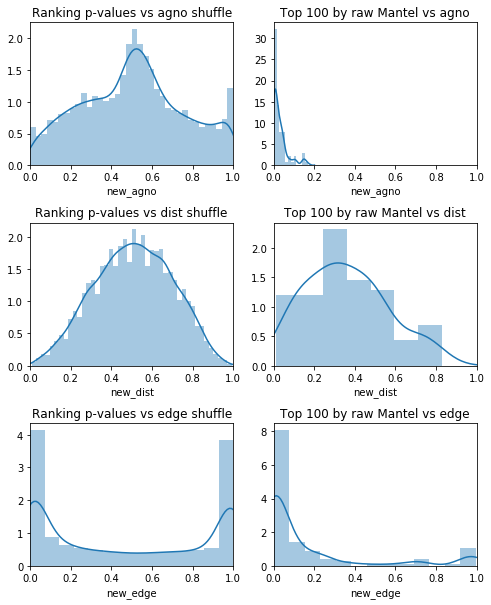

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(8, 10))
for i, shuf in enumerate(["new_agno", "new_dist", "new_edge", ]):
    sns.distplot(df_p_values[("16", "s")][shuf], ax=axes[i, 0])
    axes[i, 0].set_title("Ranking p-values vs {} shuffle".format(shuf[-4:]))
    axes[i, 0].set_xlim(left=0.0, right=1.0)
    sns.distplot(df_p_values[("16", "s")].loc[top_100_pids, shuf], ax=axes[i, 1])
    axes[i, 1].set_title("Top 100 by raw Mantel vs {}".format(shuf[-4:]))
    axes[i, 1].set_xlim(left=0.0, right=1.0)
plt.subplots_adjust(wspace=0.2, hspace=0.4)
fig.savefig("ranking_p_distributions_by_shuffle_type.png")


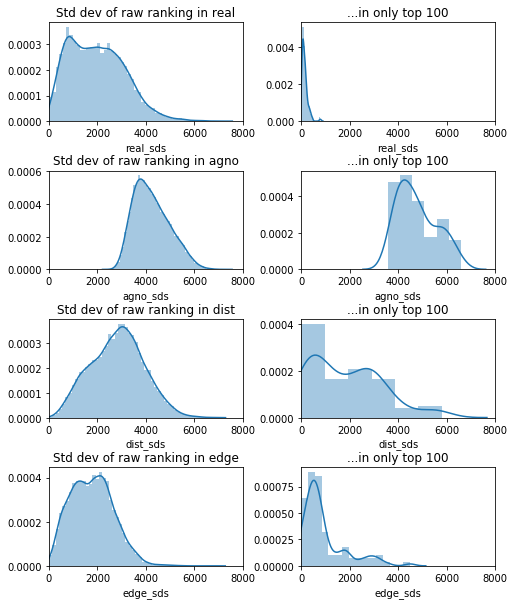

In [69]:
""" Plot standard deviation of each gene's ranking. How consistent are p-based rankings vs each permutation type? """

import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(8, 10))
for i, shuf in enumerate(["real_sds", "agno_sds", "dist_sds", "edge_sds", ]):
    sns.distplot(df_meanranks[shuf], ax=axes[i, 0])
    axes[i, 0].set_title("Std dev of raw ranking in {}".format(shuf[:4]))
    axes[i, 0].set_xlim(left=0.0, right=8000.0)
    sns.distplot(df_meanranks.loc[top_100_pids, shuf], ax=axes[i, 1])
    axes[i, 1].set_title("...in only top 100")
    axes[i, 1].set_xlim(left=0.0, right=8000.0)
plt.subplots_adjust(wspace=0.3, hspace=0.5)
fig.savefig("stdevs_in_raw_ranking_by_shuffle_type.png")


In [77]:
for shuf in ["new_agno", "new_dist", "new_edge", ]:
    print("{:,} genes rank higher in real data than {}-shuffled with p<0.05, {:,} with p<0.001".format(
        len(df_p_values[("16", "s")][df_p_values[("16", "s")][shuf] < 0.05]),
        shuf[-4:],
        len(df_p_values[("16", "s")][df_p_values[("16", "s")][shuf] < 0.001]),
    ))


410 genes rank higher in real data than agno-shuffled with p<0.05, 42 with p<0.001
53 genes rank higher in real data than dist-shuffled with p<0.05, 0 with p<0.001
4,167 genes rank higher in real data than edge-shuffled with p<0.05, 1,893 with p<0.001


In [ ]:
""" No longer necessary
    This was written to convert an old csv format to tsv, but all current files are already tsv. """

"""
import pandas as pd
import os

for mask in masks:
    for norm in norms:
        for shuffle in shuffles:
            for p_algo in ["new", "old", ]:
                filename = "./hcpww{}s{}_{}_{}_p".format(mask, norm, p_algo, shuffle)
                if os.path.isfile(filename + ".csv"):
                    print("Converting {}".format(filename))
                    df = pd.read_csv(filename + ".csv", index_col=0)
                    df.to_csv(filename + ".tsv", sep="\t")
"""

In [44]:
real_means = real_means.sort_values()


probe_id
1039414      939.4375
1017071      664.1875
1017328     1160.3750
1051636     1011.4375
1039975      848.4375
              ...    
1050699    15527.6875
1031623    15696.4375
1051216    15621.0625
1018129    15621.5625
1053551    15718.4375
Length: 15745, dtype: float64

In [45]:
real_means.sort_values()

probe_id
1040880        1.7500
1066109        2.4375
1015879       11.6875
1055725       17.7500
1033893       28.2500
              ...    
1056418    15733.0000
1019533    15733.2500
1016265    15735.5000
1014185    15736.5000
1018908    15742.5625
Length: 15745, dtype: float64

In [36]:
rankings[("16", "s")][['entrez_id', 'mean']]

,entrez_id,mean
probe_id,,
1039414,79048,1706.889031
1017071,58486,1774.614796
1017328,55857,1835.031888
1051636,6451,1837.863520
1039975,64132,1841.445153
...,...,...
1050699,7134,13940.614796
1031623,374907,13967.521684
1051216,6663,13996.479592


In [32]:
df_p_values[("16", "s")]

,entrez_id,gene_symbol,old_agno,old_dist,old_edge,new_agno,new_dist,new_edge
1039414,79048,SECISBP2,0.250732,0.848389,0.961182,0.242188,0.902344,0.980469
1017071,58486,ZBED5,0.266357,0.694092,0.985107,0.277344,0.734375,0.992188
1017328,55857,KIZ,0.336182,0.760986,0.9104,0.355469,0.835938,0.996094
1051636,6451,SH3BGRL,0.376221,0.718994,0.984375,0.375000,0.785156,0.984375
1039975,64132,XYLT2,0.260742,0.717041,0.921875,0.261719,0.769531,0.933594
...,...,...,...,...,...,...,...,...
1050699,7134,TNNC1,0.901123,0.638916,0.255127,0.863281,0.472656,0.003906
1031623,374907,B3GNT8,0.86084,0.585938,0.597412,0.796875,0.394531,0.359375
1051216,6663,SOX10,0.928223,0.730957,0.250244,0.917969,0.656250,0.089844
1018129,84968,PNMA6A,0.896973,0.683594,0.197754,0.824219,0.496094,0.000000
